# Plots

This notebook demonstrates some plotting functionality.  We primarily convert to a [Pandas](https://pandas.pydata.org/) dataframe and use the `.plot` method.  This seems to be a fairly standard approach; we just need to make sure the results are small enough to fit in memory.

First, read the data and import `pyspark.sql.functions`

In [1]:
import pyspark.sql.functions as F
df = spark.read.parquet('parquet_data/rocdev/events.parquet')

Let's look at activity by hour.  Note the use of the `%matplotlib inline` [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

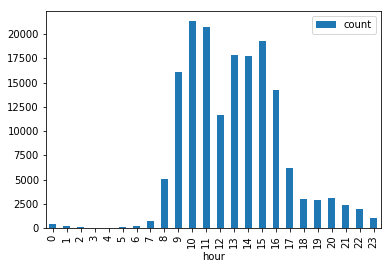

In [2]:
%matplotlib inline
activity_by_hour_df = df\
    .filter(F.col('user').isNotNull())\
    .select(F.hour(F.from_unixtime(F.col("ts"))).alias("hour"))\
    .groupBy("hour")\
    .count()\
    .orderBy("hour")
pdf = activity_by_hour_df.toPandas()
pdf.plot(x='hour', y='count', kind='bar')

So people are pretty active during "business hours" and then a little during the evening.  There's also a bit of a break during lunch. Seems reasonable.  Wonder how many users are active at various times of day.

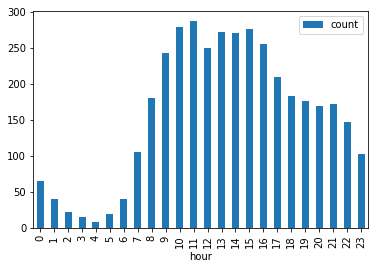

In [3]:
%matplotlib inline
users_by_hour_df = df\
    .filter(F.col('user').isNotNull())\
    .select(F.hour(F.from_unixtime(F.col("ts"))).alias("hour"), F.col("user"))\
    .distinct()\
    .groupBy("hour")\
    .count()\
    .orderBy("hour")
pdf = users_by_hour_df.toPandas()
pdf.plot(x='hour', y='count', kind='bar')

There's some interesting differences between the two graphs.  There definitely isn't a consistent ratio between activity and users.  Let's look at that.

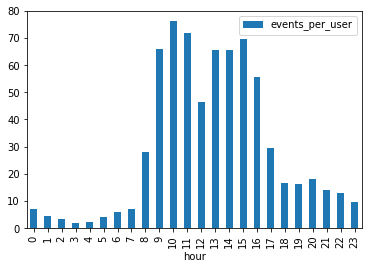

In [4]:
%matplotlib inline
by_hour_df = users_by_hour_df.\
    withColumnRenamed('count', 'active_users').\
    join(activity_by_hour_df.withColumnRenamed('count', 'events'), on='hour').\
    withColumn('events_per_user', F.col('events') / F.col('active_users')).\
    orderBy('hour')
pdf = by_hour_df.toPandas()
pdf.plot(x='hour', y='events_per_user', kind='bar')

So people appear to be more "chatty" during work hours, but they still pop in a bit during other hours.  Some of this could be "edge" effects - e.g., if a user is active and sends a few hundred messages in the 11 AM hour and then sends just a couple messages before they go for lunch at 12:15, they'll get counted as active during the 12 o'clock hour but aren't contributing much to the total.  Nothing too unexpected, but we might not have thought about it without looking at the data.

Let's look at rocdev's activity trend over its lifetime.

Text(0, 0.5, '# of events')

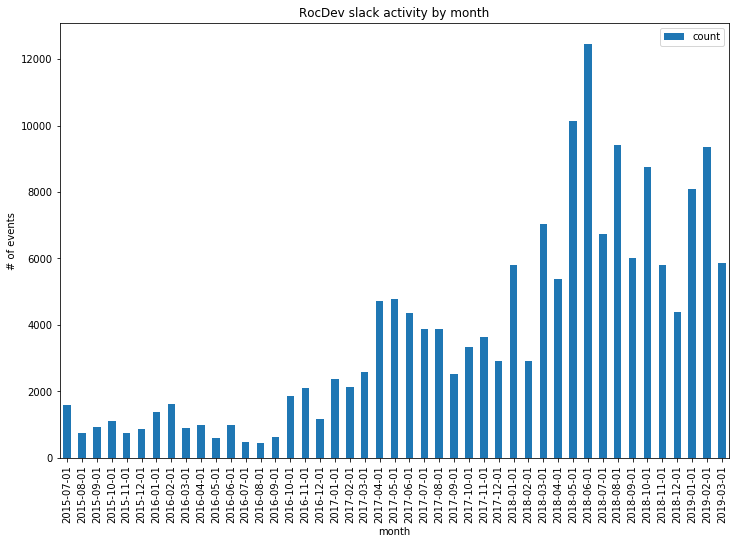

In [5]:
%matplotlib inline
by_month_df = df.\
    withColumn('month', F.trunc(F.from_unixtime(F.col('ts')), 'month')).\
    groupBy('month').\
    count().\
    orderBy('month')
pdf = by_month_df.toPandas()
ax = pdf.plot(x='month', y='count', kind='bar', title='RocDev slack activity by month', figsize=(12,8))
ax.set_ylabel('# of events')

June 2018 was the busiest month for whatever reason.  December 2018 was uncharacteristically quiet.  The overall trend is upwards.